# Basic Equilibrium

DESC is a 3D MHD equilibrium and optimization code suite, which solves the ideal MHD equilibrium equations to find stellarator equilibria. 

Like VMEC, DESC requires 4 main inputs to define the equilibrium problem:

 - Pressure Profile
 - Rotational Transform or Toroidal Current Profile
 - Last Closed Flux Surface Boundary Shape
 - Total toroidal magnetic flux enclosed by the LCFS

DESC can be run both with a text input file from the command line (e.g. `python -m desc INPUT_FILE`) or through python scripts (which offers more options than the text file for equilibrium solving and optimization). This tutorial notebook will focus on basic functionality for solving an equilibrium.

## Installing DESC

The installation instructions are located in the [installation documentation page](https://desc-docs.readthedocs.io/en/latest/installation.html#installation).

Once these instructions are followed and DESC is installed correctly, you should be able to import a module from desc such as `desc.io` without any errors.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
import desc.io

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.3+858.g53a64f3b1.dirty,using JAX backend, jax version=0.4.33, jaxlib version=0.4.33, dtype=float64
Using device: CPU, with 43.37 GB available memory


## Running DESC from a VMEC input

Perhaps the simplest way to run DESC if you already have a VMEC input file for your equilibrium is to simply pass that to DESC on the command line.

In this directory is an `input.HELIOTRON` VMEC file which contains a 19 field-period, finite beta HELIOTRON fixed boundary stellarator. To convert the input, we simply run DESC from the command line with

`python -m desc -vv input.HELIOTRON -o input.HELIOTRON_output.h5`.

You can leave out `python -m` if you've added DESC to your python path. The `-vv` flag is for double verbosity. The `-o` flag specifies the filename of the output HDF5 file (`XXX_output.h5` by default). See the [command line docs](https://desc-docs.readthedocs.io/en/latest/command_line.html#command-line-interface) for more information.

The conversion creates a new file with `_desc` appended to the file name. The above command automatically converts the VMEC input file to a DESC input file and begins solving it. There are many DESC solver options without VMEC analogs, such as the multi-grid  continuation method steps, so DESC will automatically choose a conservative continuation method when ran in this way, which is generally recommended for most equilibria to ensure robust convergence.

Generally, the most important parameters to tweak are related to the spectral resolution and the continuation method. DESC leverages a multi-grid continuation method to allow for robust convergence of highly shaped equilibria. The following parameters control this method:

### Spectral Resolution
 
- `L_rad` (int): Maximum radial mode number for the Fourier-Zernike basis.
    - default = `M_pol` if `spectral_indexing = ANSI`
    - default = `2*M_pol` if `spectral_indexing = Fringe`
    - For more information see [Basis functions and collocation nodes](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html).
- `M_pol` (int): Maximum poloidal mode number for the Fourier-Zernike basis. **Required input.**
- `N_tor` (int): Maximum toroidal mode number for the Fourier-Zernike basis.
    - default = 0
- `L_grid` (int): Radial resolution of nodes in collocation grid.
    - default = `M_grid` if `spectral_indexing = ANSI`
    - default = `2*M_grid` if `spectral_indexing = Fringe`
- `M_grid` (int): Poloidal resolution of nodes in collocation grid.
    - default = `2*M_pol`
- `N_grid` (int): Toroidal resolution of nodes in collocation grid.
    - default = `2*N_tor`

When `M_grid = M_pol`, the number of collocation nodes in each toroidal cross-section is equal to the number of Zernike polynomials in a FourierZernike basis set of the same resolution `L_rad = M_pol`. When `N_grid = N_tor`, the number of nodes with unique toroidal angles is equal to the number of terms in the toroidal Fourier series. Convergence is typically superior when the number of nodes exceeds the number of spectral coefficients, so by default the collocation grids are oversampled with respect to the spectral resolutions.

## Loading the results

DESC provides utility functions to load and compare equilibria. These will be covered in detail later in the tutorial. For now, notice that DESC saves solutions as `EquilibriaFamily` objects. An `EquilibriaFamily` is essentially a list of equilibria, which can be indexed to retrieve individual equilibria. Higher indices hold equilibria solved later in the continuation process. You can retrieve the final state of a DESC equilibrium solve with `eq = desc.io.load("XXX_output.h5")[-1]`.

In [3]:
%matplotlib inline
from desc.plotting import plot_comparison, plot_section

Number of equilibria in the EquilibriaFamily: 8


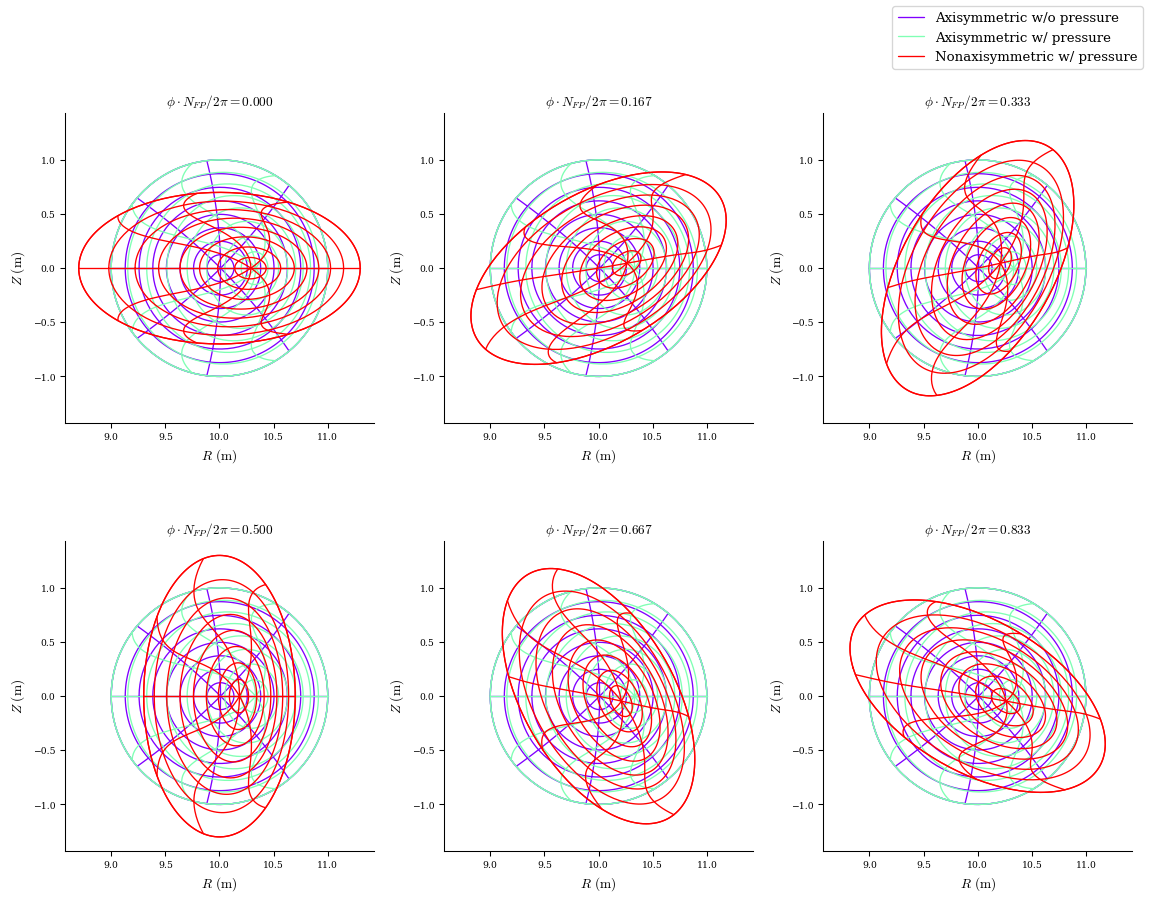

In [4]:
eq_fam = desc.io.load("input.HELIOTRON_output.h5")
print("Number of equilibria in the EquilibriaFamily:", len(eq_fam))
fig, ax = plot_comparison(
    eqs=[eq_fam[1], eq_fam[3], eq_fam[-1]],
    labels=[
        "Axisymmetric w/o pressure",
        "Axisymmetric w/ pressure",
        "Nonaxisymmetric w/ pressure",
    ],
)

## Creating an Equilibrium from scratch

The recommended way to work with DESC is through python scripts, in which we construct and solve an `Equilibrium` object.

We initialize the `Equilibrium` with the desired resolution, and the inputs specified above:
- Boundary shape, as a `FourierRZToroidalSurface`
- Profiles, as `Profile` objects (there are several different options, the most common is `PowerSeriesProfile`)
- Total flux `Psi` as a float


In [5]:
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import PowerSeriesProfile

When you already have the VMEC or DESC input file, you can instantiate an `Equilibrium` directly from the input file, using `Equilibrium.from_input_file`,

In [6]:
eq = Equilibrium.from_input_file("input.HELIOTRON")

Converting VMEC input to DESC input
Generated DESC input file input.HELIOTRON_desc:


Or, you may extract just the boundary from the input file with the `FourierRZToroidalSurface.from_input_file`:

In [7]:
surf1 = FourierRZToroidalSurface.from_input_file("input.HELIOTRON")

Converting VMEC input to DESC input
Generated DESC input file input.HELIOTRON_desc:


If you do not have an input file to work from, you can see the below steps to create an `Equilibrium` from scratch.

When starting from scratch, you can construct the surface by specifying the Fourier coefficients and mode numbers manually.

The boundary is represented by a double Fourier series for R and Z in terms of a poloidal angle $\theta$ and the geometric toroidal angle $\zeta$. We specify the mode numbers for R and Z as 2D arrays of `[m,n]` pairs, and the coefficients as a 1D array.

In DESC the double Fourier series for R and Z are defined in a slightly different manner than VMEC:

$$
\begin{align}
    R^b(\theta,\zeta) &= \sum^M \sum^N R^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)\\
    Z^b(\theta,\zeta) &= \sum^M \sum^N Z^b_{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)
\end{align}
$$

where

$$
   \mathcal{G}^{m}_{n}(\theta,\zeta) = \begin{cases}
   \cos(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m\ge0, n\ge0 \\
   \cos(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m\ge0, n<0 \\
   \sin(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m<0, n\ge0 \\
   \sin(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m<0, n<0.
   \end{cases}
$$

**Note**: in DESC, radial modes are indexed by `l`, poloidal modes by `m`, and toroidal modes by `n`

In [8]:
surf2 = FourierRZToroidalSurface(
    R_lmn=[10.0, -1.0, -0.3, 0.3],
    modes_R=[
        (0, 0),
        (1, 0),
        (1, 1),
        (-1, -1),
    ],  # (m,n) pairs corresponding to R_mn on previous line
    Z_lmn=[1, -0.3, -0.3],
    modes_Z=[(-1, 0), (-1, 1), (1, -1)],
    NFP=19,
)

For profiles, we will use the standard `PowerSeriesProfile` which represents a function as a power series in the radial coordinate $\rho$ which is the square root of the normalized toroidal flux: $\rho = \sqrt{\Psi/\Psi_b}$ (Note this is different from VMEC which uses the normalized toroidal flux without the square root). We could also use splines (`SplineProfile`), or Zernike polynomials (`FourierZernikeProfile`), for more options, see the [`desc.profiles` module](https://desc-docs.readthedocs.io/en/stable/api.html#profiles)

In [9]:
pressure = PowerSeriesProfile(
    [1.8e4, 0, -3.6e4, 0, 1.8e4]
)  # coefficients in ascending powers of rho
iota = PowerSeriesProfile([1, 0, 1.5])  # 1 + 1.5 r^2

Finally, we create the equilibrium using the objects we just made, leaving the other parameters at their defaults. The number of field periods by default is inferred from the given surface.

In [10]:
eq = Equilibrium(
    L=8,  # radial resolution
    M=8,  # poloidal resolution
    N=3,  # toroidal resolution
    surface=surf1,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # total flux, in Webers
)

We now have an `Equilibrium` object, but it is generally not actually in equilibrium, as the default initial guess is just to scale the outermost flux surface.

To find the actual solution, we must solve the equilibrium. There are two primary ways to do this in DESC:

- `eq.solve` is a method of the `Equilibrium` class that is best used when starting close to the correct solution, or for refining a solution after optimization, for example. Generally not recommended for "cold start" solves.
- `desc.continuation.solve_continuation_automatic` uses a multi-grid continuation method to arrive at a particular desired equilibrium. It is generally very robust, and is the recommended method.

Here, we will use both methods

In [11]:
eq1, info = eq.solve(verbose=3, copy=True)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 624 ms
Timer: Objective build = 1.02 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.02 sec
Timer: Linear constraint projection build = 5.04 sec
Number of parameters: 351
Number of objectives: 2106
Timer: Initializing the optimization = 7.13 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          9.095e-01                                    6.282e-01   
       1              2          7.594e-02      8.335e-01      2.539e-

In [12]:
from desc.continuation import solve_continuation_automatic

eqf = solve_continuation_automatic(eq.copy(), verbose=3)

Step 1
Spectral indexing: ansi
Spectral resolution (L,M,N)=(6,6,0)
Node resolution (L,M,N)=(12,12,0)
Boundary ratio = 0
Pressure ratio = 0
Perturbation Order = 2
Objective: force
Optimizer: lsq-exact
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.16 sec
Timer: Objective build = 1.27 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 714 ms
Timer: Linear constraint projection build = 3.61 sec
Number of parameters: 27
Number of objectives: 98
Timer: Initializing the optimization = 5.65 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduc

`solve_continuation_automatic` starts with a low resolution vacuum axisymmetric solution, and proceeds to increase the pressure, boundary shaping, and resolution until the final desired configuration is reached. It returns not just the final equilibrium, but each step along the way, as an `EquilibriaFamily`. 

Finally, we can look at the differences between the two methods, and the initial guess

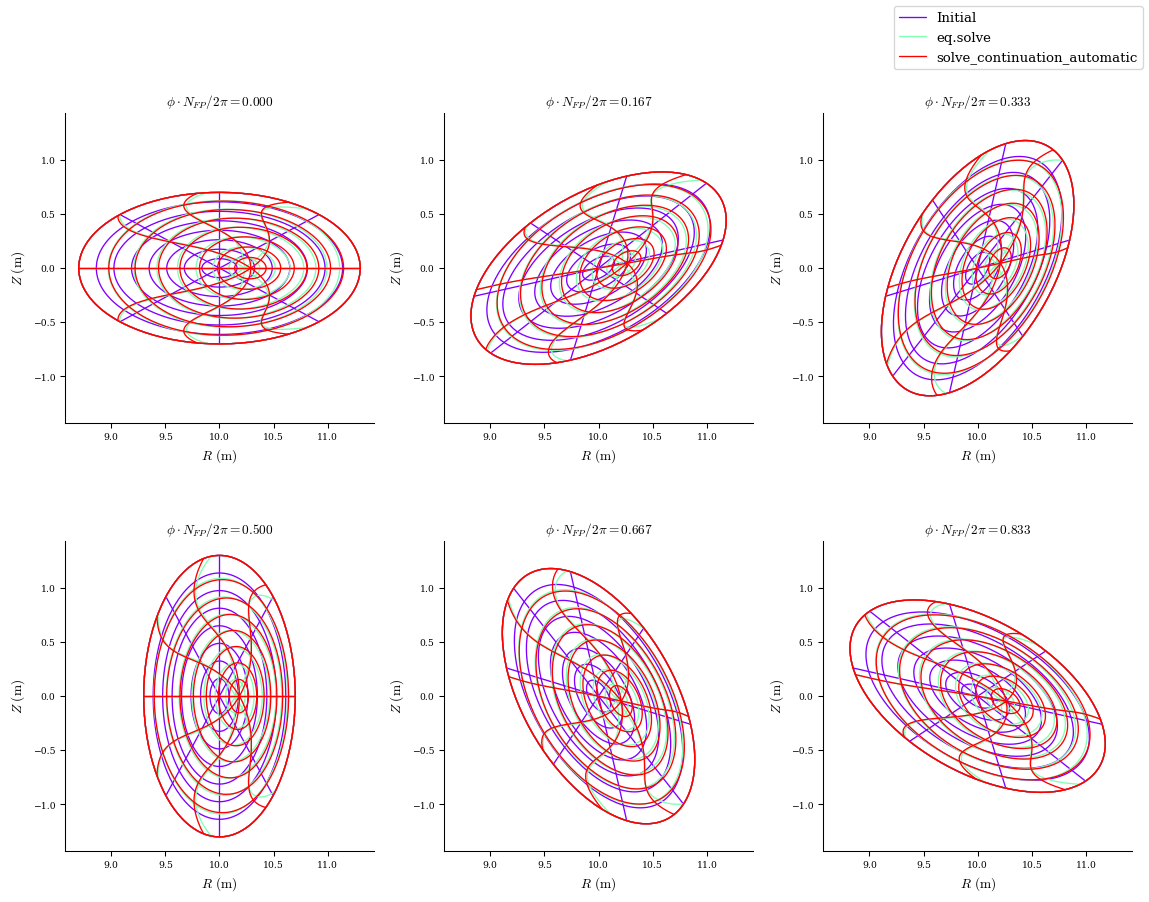

In [13]:
plot_comparison(
    [eq, eq1, eqf[-1]], labels=["Initial", "eq.solve", "solve_continuation_automatic"]
);

If we compute the normalized force balance error for each case, we see that using the continuation method gives ~20% lower error, indicating a better solution. For more complex equilibria this difference will often be much larger, which is why the continuation method is usually recommended.

In [14]:
f1 = (
    eq1.compute("<|F|>_vol")["<|F|>_vol"]
    / eq1.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eqf[-1].compute("<|F|>_vol")["<|F|>_vol"]
    / eqf[-1].compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error after eq.solve(): {f1:.4e}")
print(f"Force error after solve_continuation_automatic: {f2:.4e}")

Force error after eq.solve(): 9.3711e-03
Force error after solve_continuation_automatic: 7.3831e-03
